<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/tutorials/advanced/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-Foundation/FinRL/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for portfolio alloacation. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A represents the weight of a stock in the porfolio: a ∈ (-1,1). Assume our stock pool includes N stocks, we can use a list [a<sub>1</sub>, a<sub>2</sub>, ... , a<sub>N</sub>] to determine the weight for each stock in the porfotlio, where a<sub>i</sub> ∈ (-1,1), a<sub>1</sub>+ a<sub>2</sub>+...+a<sub>N</sub>=1. For example, "The weight of AAPL in the portfolio is 10%." is [0.1 , ...].

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
      
# install finrl library
#%pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


Num GPUs Available:  1



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
import sys
sys.path.append("../FinRL-Library")


/home/bassem/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [5]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [6]:
dp = YahooFinanceProcessor()
df = dp.download_data(start_date = '2008-01-01',
                     end_date = '2021-10-31',
                     ticker_list = config_tickers.DOW_30_TICKER, time_interval='1D')

[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/data_processors/processor_yahoofinance.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Shape of DataFrame:  (101615, 9)


In [7]:
df.head()

,date,open,high,low,close,adjcp,volume,tic,day
0,2008-01-02,7.116786,7.152143,6.876786,6.958571,5.949703,1079178800,AAPL,2
1,2008-01-02,46.599998,47.040001,46.259998,46.599998,35.443794,7934400,AMGN,2
2,2008-01-02,52.090000,52.320000,50.790001,51.040001,40.326855,8053700,AXP,2
3,2008-01-02,87.570000,87.839996,86.000000,86.620003,63.481628,4303000,BA,2
4,2008-01-02,72.559998,72.669998,70.050003,70.629997,47.176800,6337800,CAT,2


In [8]:
df.shape

(101615, 9)

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)

/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/preprocessor/preprocessors.py:158: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ve

Successfully added technical indicators


In [10]:
df.shape

(97524, 17)

In [11]:
df.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,6.958571,5.949703,1079178800,AAPL,2,0.0,6.964725,6.955632,100.0,-66.666667,100.0,6.958571,6.958571
3483,2008-01-02,46.599998,47.040001,46.259998,46.599998,35.443794,7934400,AMGN,2,0.0,6.964725,6.955632,100.0,-66.666667,100.0,46.599998,46.599998
6966,2008-01-02,52.090000,52.320000,50.790001,51.040001,40.326855,8053700,AXP,2,0.0,6.964725,6.955632,100.0,-66.666667,100.0,51.040001,51.040001
10449,2008-01-02,87.570000,87.839996,86.000000,86.620003,63.481628,4303000,BA,2,0.0,6.964725,6.955632,100.0,-66.666667,100.0,86.620003,86.620003
13932,2008-01-02,72.559998,72.669998,70.050003,70.629997,47.176800,6337800,CAT,2,0.0,6.964725,6.955632,100.0,-66.666667,100.0,70.629997,70.629997


## Add covariance matrix as states

In [12]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
        

In [13]:
df.shape

(90468, 19)

In [14]:
df.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,3.048214,2.606278,607541200,AAPL,2,-0.097446,3.649552,2.895305,42.254771,-80.847207,16.129793,3.243631,3.375887,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,57.750000,43.924454,6287200,AMGN,2,0.216368,58.947401,56.388599,51.060614,51.895357,10.432018,56.671334,56.044333,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,18.549999,14.852881,9625600,AXP,2,-1.191668,23.723023,16.106977,42.521170,-74.811722,25.776759,20.030000,22.412000,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,42.669998,32.005886,5443100,BA,2,-0.391219,42.894634,38.486366,47.290375,157.922391,5.366299,40.432000,43.304500,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,44.669998,30.628826,6277400,CAT,2,0.979845,45.785565,38.404435,51.073052,98.904653,26.331746,40.266000,39.918333,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.


## Training data split: 2009-01-01 to 2020-07-01

In [15]:
train = data_split(df, '2009-01-01','2020-07-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)

In [16]:
train.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.771173,746015200,AAPL,4,-0.082758,3.633600,2.892864,45.440193,-30.508777,2.140064,3.244631,3.376833,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,58.590000,59.080002,57.750000,58.990002,44.867596,6547900,AMGN,4,0.320448,59.148360,56.339640,52.756859,94.549630,0.814217,56.759667,56.166000,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,18.570000,19.520000,18.400000,19.330000,15.477425,10955700,AXP,4,-1.059847,23.489423,16.086577,43.923322,-42.018825,16.335101,20.028333,22.263333,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,42.799999,45.560001,42.779999,45.250000,33.941090,7010200,BA,4,-0.019566,43.926849,37.932151,50.664690,275.696308,20.494464,40.621667,43.237334,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...
0,2009-01-02,44.910000,46.980000,44.709999,46.910000,32.164726,7117200,CAT,4,1.248426,46.543072,38.372928,53.534743,131.675975,34.637448,40.623333,39.911333,"[[0.001366150662406761, 0.000433938195725591, ...",tic AAPL AMGN AXP ...


## Environment for Portfolio Allocation


In [17]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [18]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 28, State Space: 28


In [19]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [20]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [21]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [22]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device


In [23]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

-------------------------------------
| time/                 |           |
|    fps                | 454       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -39.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.8e+08   |
|    reward             | 1523248.6 |
|    std                | 0.997     |
|    value_loss         | 2.44e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 463       |
|    iterations         | 200       |
|    time_elapsed       | 2         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -39.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updat

In [24]:
trained_a2c.save('trained_a2c.zip')

### Model 2: **PPO**


In [25]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device


In [26]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000)

----------------------------------
| time/              |           |
|    fps             | 653       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 3248046.2 |
----------------------------------
begin_total_asset:1000000
end_total_asset:4276221.2118751295
Sharpe:  0.7834859829760609
--------------------------------------------
| time/                   |                |
|    fps                  | 593            |
|    iterations           | 2              |
|    time_elapsed         | 6              |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | -1.1787051e-08 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -39.7          |
|    explained_variance   | 0              |
|    learning_rate        | 0.0001         |
|    loss  

In [27]:
trained_ppo.save('trained_ppo.zip')

### Model 3: **DDPG**


In [28]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [29]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:4364108.027940071
Sharpe:  0.7815462635076222
begin_total_asset:1000000
end_total_asset:4538970.724456399
Sharpe:  0.8135913785007729
begin_total_asset:1000000
end_total_asset:4538970.724456399
Sharpe:  0.8135913785007729
begin_total_asset:1000000
end_total_asset:4538970.724456399
Sharpe:  0.8135913785007729
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 209       |
|    time_elapsed    | 55        |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -7.84e+07 |
|    critic_loss     | 4.03e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 4538970.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:4538970.724456399
Sharpe:  0.8135913785007729
begin_total_asset:1000000
end_total_asset:4538970.724456399
Sharpe:  0.8135913785007729
begin_total_asset

In [30]:
trained_ddpg.save('trained_ddpg.zip')

### Model 4: **SAC**


In [31]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [32]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

begin_total_asset:1000000
end_total_asset:4387401.683906057
Sharpe:  0.8032212566648127
begin_total_asset:1000000
end_total_asset:4410702.329001743
Sharpe:  0.8058725896509364
begin_total_asset:1000000
end_total_asset:4410682.387629655
Sharpe:  0.8058724758779349
begin_total_asset:1000000
end_total_asset:4410885.348141572
Sharpe:  0.8058906054947578
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 98        |
|    time_elapsed    | 117       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -1.06e+08 |
|    critic_loss     | 1.03e+12  |
|    ent_coef        | 3.25      |
|    ent_coef_loss   | -190      |
|    learning_rate   | 0.0003    |
|    n_updates       | 11471     |
|    reward          | 4410885.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:4410494.057265694
Sharpe:  0.8058436616108094
begin_total_asset:1000000
end_total

In [33]:
trained_sac.save('trained_sac.zip')

### Model 5: **TD3**


In [34]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [35]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

begin_total_asset:1000000
end_total_asset:4579471.312265347
Sharpe:  0.7941430807740805
begin_total_asset:1000000
end_total_asset:4941168.269040824
Sharpe:  0.8131200730881819
begin_total_asset:1000000
end_total_asset:4941168.269040824
Sharpe:  0.8131200730881819
begin_total_asset:1000000
end_total_asset:4941168.269040824
Sharpe:  0.8131200730881819
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 204       |
|    time_elapsed    | 56        |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -4.31e+07 |
|    critic_loss     | 3.25e+12  |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 4941168.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:4941168.269040824
Sharpe:  0.8131200730881819
begin_total_asset:1000000
end_total_asset:4941168.269040824
Sharpe:  0.8131200730881819
begin_total_asset

In [36]:
trained_td3.save('trained_td3.zip')

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

In [37]:
trade = data_split(df,'2020-07-01', '2021-10-31')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [38]:
trade.shape

(9436, 19)

In [39]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1402399.2494226778
Sharpe:  1.9119615292640058
hit end!


In [40]:
df_daily_return.head()

,date,daily_return
0,2020-07-01,0.000000
1,2020-07-02,0.004819
2,2020-07-06,0.016452
3,2020-07-07,-0.015480
4,2020-07-08,0.006485


In [41]:
df_daily_return.to_csv('df_daily_return.csv')

In [42]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,...,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
2020-07-02,0.039701,0.026236,0.030752,0.043605,0.038114,0.026236,0.026236,0.026236,0.026236,0.026236,...,0.071316,0.040611,0.065329,0.071316,0.026236,0.071316,0.026236,0.026236,0.039041,0.026236
2020-07-06,0.039702,0.026236,0.030753,0.043606,0.038115,0.026236,0.026236,0.026236,0.026236,0.026236,...,0.071316,0.040610,0.065328,0.071316,0.026236,0.071316,0.026236,0.026236,0.039042,0.026236
2020-07-07,0.039702,0.026236,0.030753,0.043606,0.038115,0.026236,0.026236,0.026236,0.026236,0.026236,...,0.071316,0.040610,0.065328,0.071316,0.026236,0.071316,0.026236,0.026236,0.039042,0.026236
2020-07-08,0.039702,0.026236,0.030753,0.043606,0.038115,0.026236,0.026236,0.026236,0.026236,0.026236,...,0.071316,0.040610,0.065328,0.071316,0.026236,0.071316,0.026236,0.026236,0.039042,0.026236


In [43]:
df_actions.to_csv('df_actions.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [44]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

/home/bassem/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [45]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.287736
Cumulative returns     0.402399
Annual volatility      0.137244
Sharpe ratio           1.911962
Calmar ratio           3.774671
Stability              0.914023
Max drawdown          -0.076228
Omega ratio            1.371956
Sortino ratio          2.897786
Skew                  -0.195364
Kurtosis               0.930774
Tail ratio             1.039031
Daily value at risk   -0.016250
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [46]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)
Annual return          0.279047
Cumulative returns     0.388402
Annual volatility      0.139129
Sharpe ratio           1.844560
Calmar ratio           3.124551
Stability              0.918675
Max drawdown          -0.089308
Omega ratio            1.358960
Sortino ratio          2.734872
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016510
dtype: float64


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/bassem/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (337, 8)


/home/bassem/anaconda3/lib/python3.9/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/bassem/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2020-07-01
End date,2021-10-29
Total months,16
,Backtest
Annual return,28.774%
Cumulative returns,40.24%
Annual volatility,13.724%
Sharpe ratio,1.91
Calmar ratio,3.77
Stability,0.91
Max drawdown,-7.623%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.62,2020-09-02,2020-10-30,2020-11-09,49
1,5.51,2021-08-16,2021-09-30,NaT,NaN
2,4.05,2021-06-04,2021-06-18,2021-06-30,19
3,3.29,2021-01-21,2021-01-29,2021-02-05,12
4,3.25,2021-05-07,2021-05-12,2021-06-04,21


/home/bassem/anaconda3/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/bassem/anaconda3/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/bassem/anaconda3/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/bassem/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. 

Stress Events,mean,min,max
New Normal,0.10%,-3.12%,3.36%


/home/bassem/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


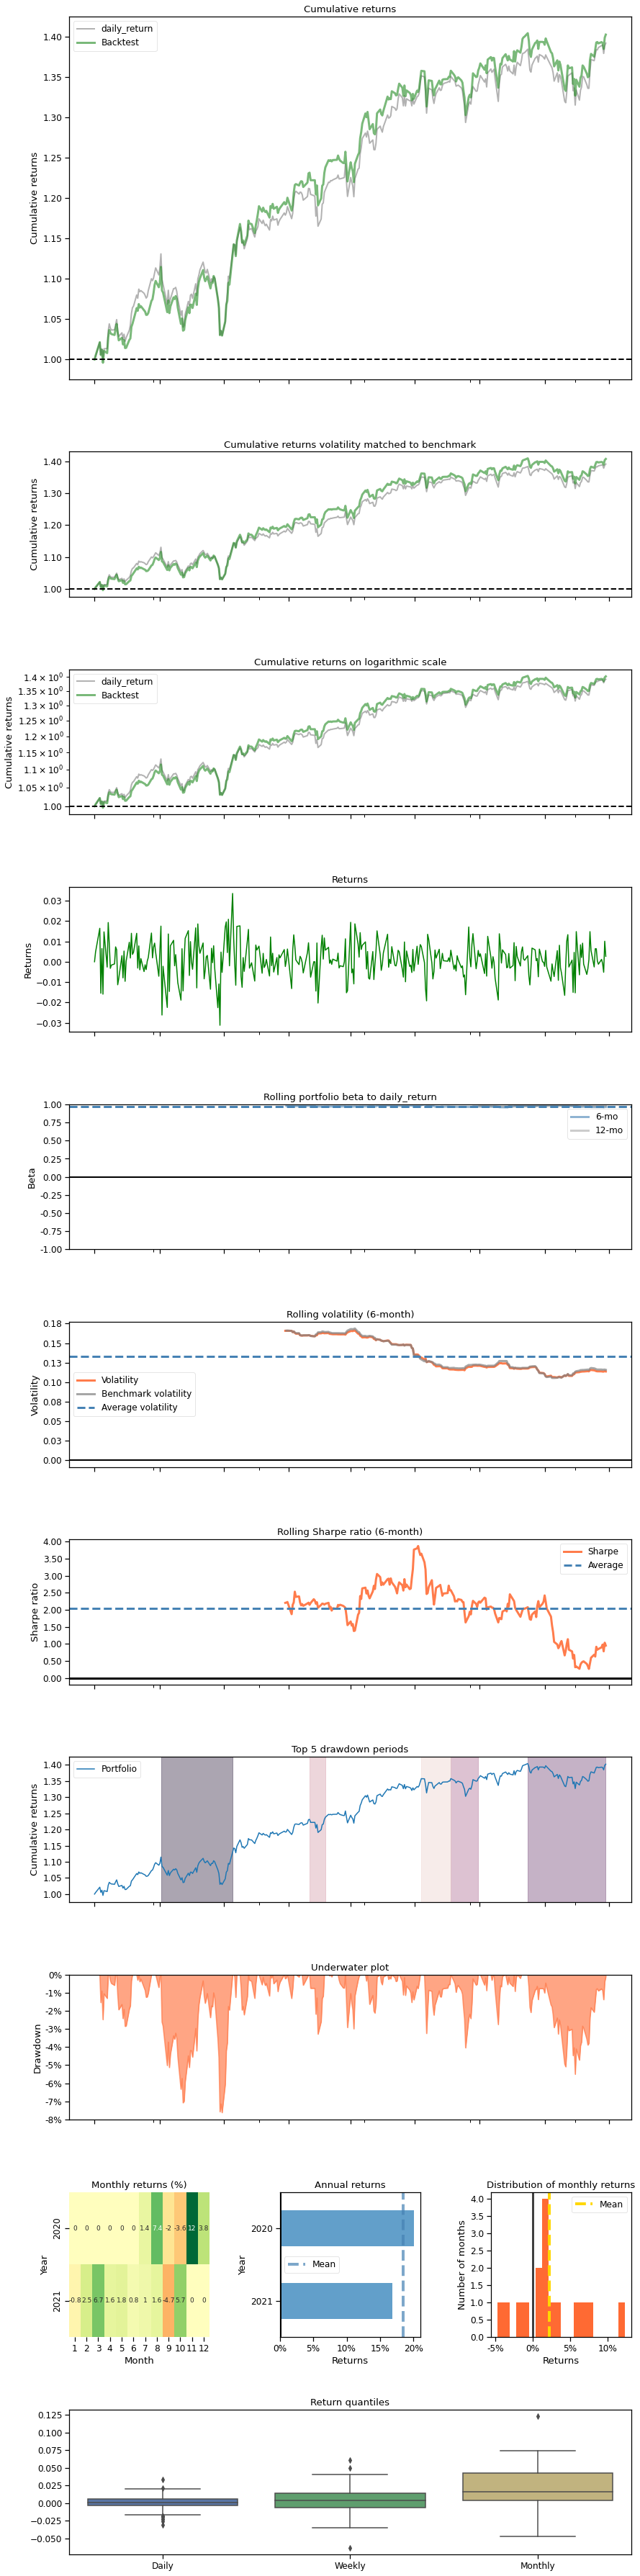

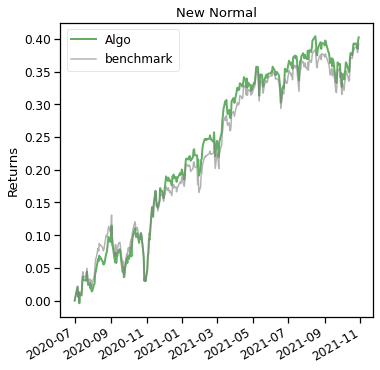

In [47]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2021-11-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

## Min-Variance Portfolio Allocation

In [48]:
%pip install PyPortfolioOpt

/bin/bash: /home/bassem/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [49]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [50]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [51]:
df.head()

,date,open,high,low,close,adjcp,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,3.048214,2.606278,607541200,AAPL,2,-0.097446,3.649552,2.895305,42.254771,-80.847207,16.129793,3.243631,3.375887,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,57.750000,43.924454,6287200,AMGN,2,0.216368,58.947401,56.388599,51.060614,51.895357,10.432018,56.671334,56.044333,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,18.549999,14.852881,9625600,AXP,2,-1.191668,23.723023,16.106977,42.521170,-74.811722,25.776759,20.030000,22.412000,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,42.669998,32.005886,5443100,BA,2,-0.391219,42.894634,38.486366,47.290375,157.922391,5.366299,40.432000,43.304500,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,44.669998,30.628826,6277400,CAT,2,0.979845,45.785565,38.404435,51.073052,98.904653,26.331746,40.266000,39.918333,"[[0.001348968986171653, 0.00042841264280825875...",tic AAPL AMGN AXP ...


In [52]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

In [53]:
portfolio.head()

,account_value
2020-07-01,1000000
2020-07-02,1005234.883501
2020-07-06,1014933.780399
2020-07-07,1014238.666671
2020-07-08,1012674.038646


In [54]:
a2c_cumpod =(df_daily_return.daily_return+1).cumprod()-1

In [55]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1

In [56]:
dji_cumpod =(baseline_returns+1).cumprod()-1

## Plotly: DRL, Min-Variance, DJIA

In [57]:
%pip install plotly

/bin/bash: /home/bassem/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [58]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [59]:
time_ind = pd.Series(df_daily_return.date)

In [60]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
#trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [61]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)



fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()